First, let's import all the necessary dependencies.

In [1]:
import display
import matplotlib.pyplot as plt
import xarray as xr

Let's define some configuration variables.

In [2]:
AREA = {"latitude": slice(55, 47), "longitude": slice(5, 16)}
DATASET = "s3://ecmwf-era5-single-levels/reanalysis-era5-single-levels.zarr"
LOCATION = {"latitude": 52.5, "longitude": 13.4}
REFERENCE_PERIOD = slice("1981", "2010")
MONTH = "2023-10"

In the following lines we:
- establish a connection with the remote dataset
- show its metadata

It is worth noticing that, in the first operation, only the information necessary to gather the dataset's metadata (e.g. its sizes, dimensions, variables' type and attributes) is actually downloaded from its remote location to the local machine.

In [3]:
ds = xr.open_dataset(DATASET, chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 735600, latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-29T17:46 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

Here we want to compute the average October 2023 temperature on an area comprising the entire territory of Germany. 

Note that the operations prescribed in the following lines are actually performed, and the resulting data downloaded, only when the `.compute()` method is met. For this reason, as a general rule to maximize efficiency, the `compute()` method should be placed after an operation which significantly reduce the amount of data, such as after selection and reduction operations.

In [4]:
t2m = ds.t2m - 273.15
t2m.attrs["units"] = "C"
t2m_area = t2m.sel(**AREA)
t2m_area_month = t2m_area.sel(valid_time="2023-10")
t2m_area_month_mean = t2m_area_month.mean(dim="valid_time")
t2m_area_month_mean

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
dask.array<mean_agg-aggregate, shape=(33, 45), dtype=float32, chunksize=(33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 ...
    surface    float64 ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

In [5]:
%%time
%%capture

t2m_area_month_mean = t2m_area_month_mean.compute()

CPU times: user 518 ms, sys: 189 ms, total: 707 ms
Wall time: 593 ms


Let's plot the result on a map.

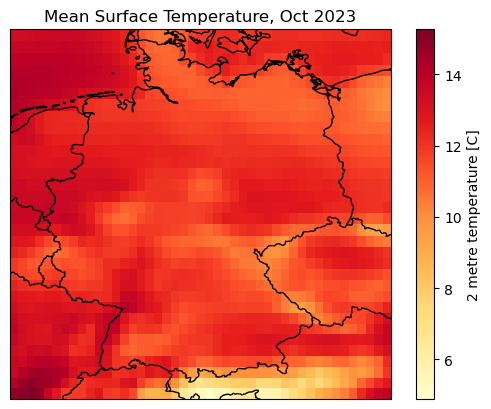

In [6]:
display.map(t2m_area_month_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Oct 2023")

Now, we want to compute the average October 2023 temperature anomaly on an area comprising the entire territory of Germany. 

The same considerations done before apply here.

In [7]:
t2m = ds.t2m - 273.15
t2m.attrs["units"] = "C"
t2m_area = t2m.sel(**AREA)
t2m_month = t2m_area.sel(valid_time=t2m_area["valid_time.month"] == 10)

In [8]:
%%time

t2m_month = t2m_month.compute()
t2m_month_ref_mean = t2m_month.sel(valid_time=REFERENCE_PERIOD).mean(dim="valid_time")
t2m_month_year = t2m_area.sel(valid_time="2023-10")
t2m_month_year_mean = t2m_month_year.mean(dim="valid_time").compute()
t2m_month_year_anomaly = (t2m_month_year_mean - t2m_month_ref_mean)

CPU times: user 25.7 s, sys: 8.25 s, total: 33.9 s
Wall time: 18.1 s


Let's plot the results on a map.

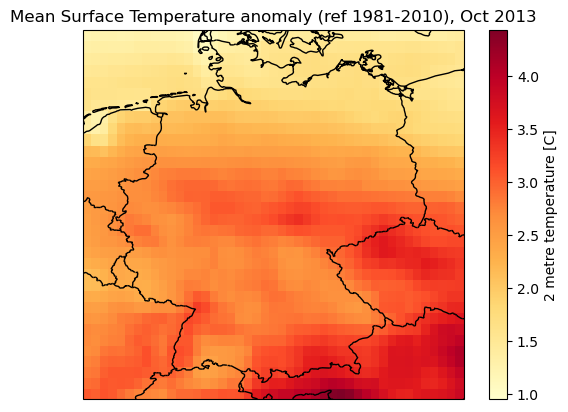

In [9]:
display.map(
    t2m_month_year_anomaly, 
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature anomaly (ref 1981-2010), Oct 2013"
)

Finally, we want to compute 2-metre Temperature climatology (mean and standard deviation for each month of the year) over the time range 1981-2010 in Berlin, and compare it with 2023 monthly means.

The same considerations done before apply here.

In [10]:
t2m =  ds.t2m
t2m_loc = t2m.sel(**LOCATION, method="nearest")
t2m_loc

<xarray.DataArray 't2m' (valid_time: 735600)>
dask.array<getitem, shape=(735600,), dtype=float32, chunksize=(2880,), chunktype=numpy.ndarray>
Coordinates:
    latitude    float64 52.5
    longitude   float64 13.5
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

In [11]:
%%time

t2m_loc = t2m_loc.compute()
t2m_climatology_mean = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").mean(dim="valid_time")
t2m_climatology_std = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").std(dim="valid_time")
t2m_monthly_mean = t2m_loc.sel(valid_time="2023").resample(valid_time="1M").mean(dim="valid_time")

CPU times: user 35.8 s, sys: 9.21 s, total: 45.1 s
Wall time: 29.5 s


Let's plot the results.

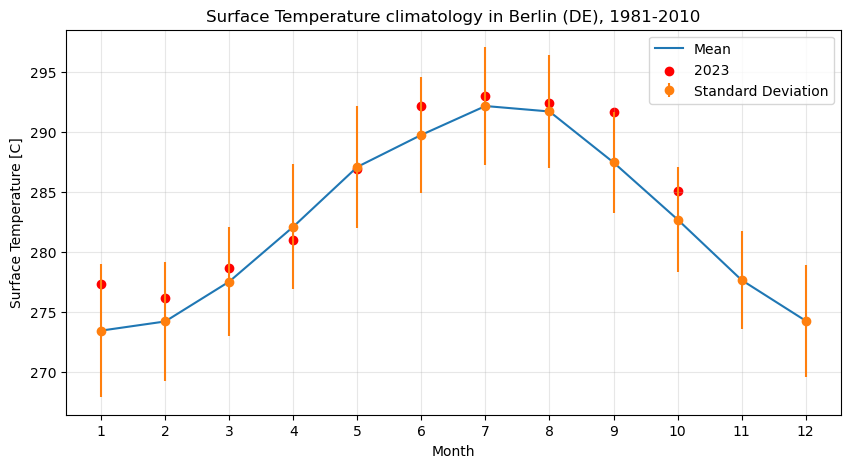

In [12]:
plt.figure(figsize=(10, 5))
t2m_climatology_mean.plot(label='Mean')
plt.errorbar(t2m_climatology_mean.month, t2m_climatology_mean, yerr=t2m_climatology_std, fmt='o', label='Standard Deviation')
for month in range (1, 11):
    t2m_point = t2m_monthly_mean.sel(valid_time=t2m_monthly_mean["valid_time.month"]==month)
    label = None
    if month == 1:
        label = "2023"
    plt.scatter(month, t2m_point, color='red', label=label)
plt.title('Surface Temperature climatology in Berlin (DE), 1981-2010')
plt.xticks(t2m_climatology_mean.month)
plt.xlabel('Month')
plt.ylabel('Surface Temperature [C]')
plt.legend()
plt.grid(alpha=0.3)
plt.show()